<a href="https://www.kaggle.com/code/nadivaaliyya/pokemon-gen-1-9-deep-dive-analysis-python?scriptVersionId=188464744" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
##Importing the necessary libraries

import numpy as np #for linear algebra
import pandas as pd #dataframe for data processing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

##define the dataset

df_pokemon = pd.read_csv("/kaggle/input/pokemon-stats-gen-1-9/PokemonStats.csv")
df_pokemon.head(n=5) #show what the data looks like


/kaggle/input/pokemon-stats-gen-1-9/PokemonStats.csv


,ID,Name,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Type1,Type2,Height,Weight
0,1,Bulbasaur,318,45,49,49,65,65,45,Grass,Poison,0.7,6.9
1,2,Ivysaur,405,60,62,63,80,80,60,Grass,Poison,1.0,13.0
2,3,Venusaur,525,80,82,83,100,100,80,Grass,Poison,2.0,100.0
3,3,Venusaur Mega Venusaur,625,80,100,123,122,120,80,Grass,Poison,2.4,155.5
4,4,Charmander,309,39,52,43,60,50,65,Fire,NaN,0.6,8.5


# Expected Output - What Will Be Analyzed
1. Type distribution for each generation
2. Most popular dual type combination
3. Single type pokemon vs dual type pokemon stats

# Examining & Data Preparation

In [2]:
##Examining dataset

print(df_pokemon.dtypes) #display data types

ID           int64
Name        object
Total        int64
HP           int64
Attack       int64
Defense      int64
SpAtk        int64
SpDef        int64
Speed        int64
Type1       object
Type2       object
Height     float64
Weight     float64
dtype: object


In [3]:
print(df_pokemon.isnull().sum()) #check for missing values

ID           0
Name         0
Total        0
HP           0
Attack       0
Defense      0
SpAtk        0
SpDef        0
Speed        0
Type1        0
Type2      542
Height       0
Weight       1
dtype: int64


In [4]:
## Cleaning the data

#For this analysis, we will not be dropping rows with null Type 2. We will just be replacing null weight with the value 0.

#Checking what Pokemon (row) has null weight
print(df_pokemon[df_pokemon['Weight'].isnull()]) #ok it's Eternatus

       ID                 Name  Total   HP  Attack  Defense  SpAtk  SpDef  \
1058  890  Eternatus Eternamax   1125  255     115      250    125    250   

      Speed   Type1   Type2  Height  Weight  
1058    130  Poison  Dragon   100.0     NaN  


In [5]:
#Replace null value in Eternatus with 0 type float64
df_pokemon['Weight'] = df_pokemon['Weight'].fillna(0).astype('float64')
print(df_pokemon.isnull().sum()) #check the cleaned data to ensure no more missing values

ID           0
Name         0
Total        0
HP           0
Attack       0
Defense      0
SpAtk        0
SpDef        0
Speed        0
Type1        0
Type2      542
Height       0
Weight       0
dtype: int64


In [6]:
##Adding 'Generation' column

#Since this dataset doesn't have generation information, we will add the column manually

def get_generation(pokedex_number):
    if 1 <= pokedex_number <= 151:
        return 1
    elif 152 <= pokedex_number <= 251:
        return 2
    elif 252 <= pokedex_number <= 386:
        return 3
    elif 387 <= pokedex_number <= 493:
        return 4
    elif 494 <= pokedex_number <= 649:
        return 5
    elif 650 <= pokedex_number <= 721:
        return 6
    elif 722 <= pokedex_number <= 809:
        return 7
    elif 810 <= pokedex_number <= 898:
        return 8
    elif 899 <= pokedex_number <= 1010:
        return 9
    else:
        return None

# Add the 'generation' column
df_pokemon['Generation'] = df_pokemon['ID'].apply(get_generation)
print(df_pokemon.head(n=5))

   ID                    Name  Total  HP  Attack  Defense  SpAtk  SpDef  \
0   1               Bulbasaur    318  45      49       49     65     65   
1   2                 Ivysaur    405  60      62       63     80     80   
2   3                Venusaur    525  80      82       83    100    100   
3   3  Venusaur Mega Venusaur    625  80     100      123    122    120   
4   4              Charmander    309  39      52       43     60     50   

   Speed  Type1   Type2  Height  Weight  Generation  
0     45  Grass  Poison     0.7     6.9           1  
1     60  Grass  Poison     1.0    13.0           1  
2     80  Grass  Poison     2.0   100.0           1  
3     80  Grass  Poison     2.4   155.5           1  
4     65   Fire     NaN     0.6     8.5           1  


# 1. Type Distribution for Each Generation

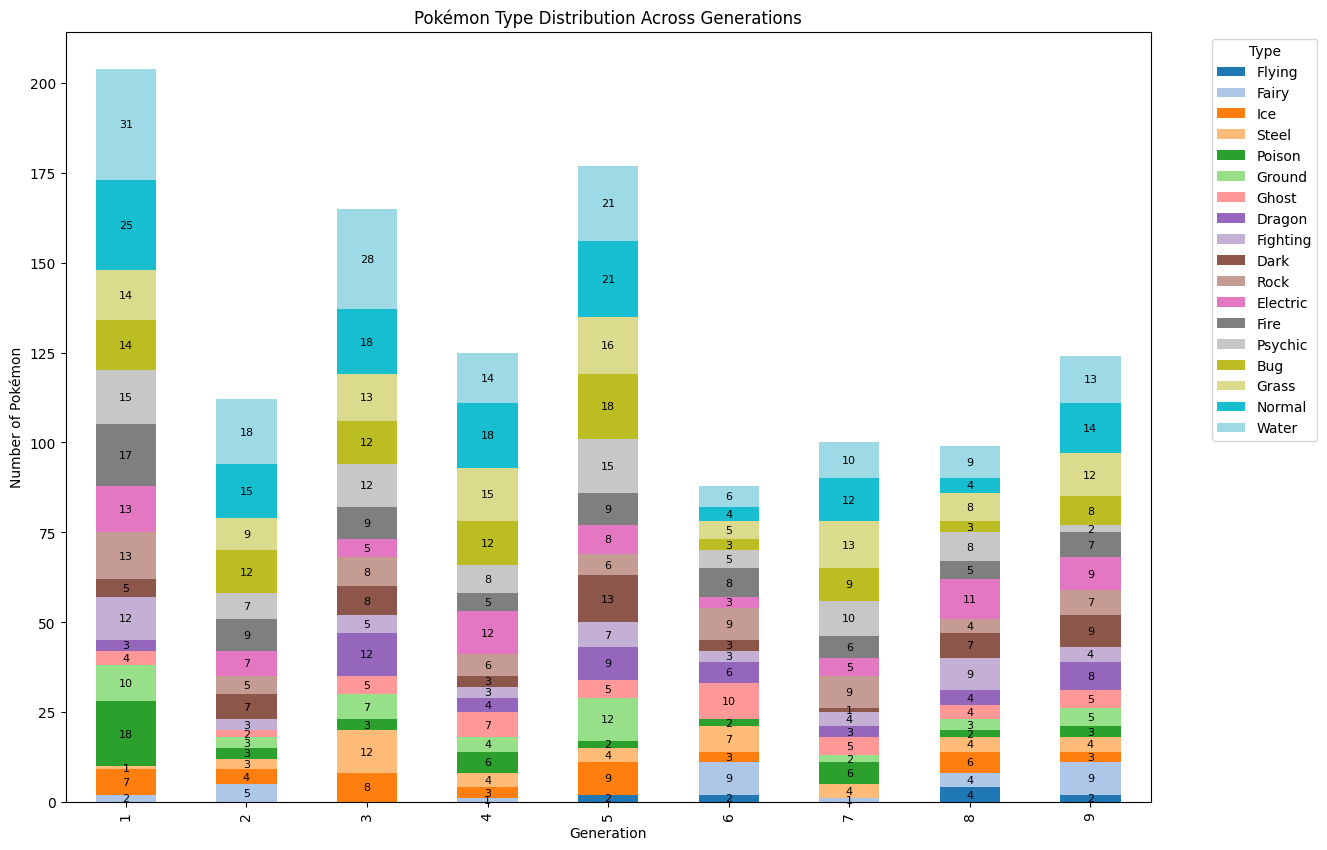

In [7]:
##Visualizing generation type distribution

# Import another package for visualization
import matplotlib.pyplot as plt #for data visualization

#Since there are only 1 value for type1, no need to use .explode()

type_distribution = df_pokemon.groupby(['Generation','Type1']).size().unstack(fill_value=0)

#Ok I want to visualize the data so that the stacked bar are in ascending order from the most common type to the leas
sorted_columns = type_distribution.sum().sort_values(ascending=True).index
type_distribution = type_distribution[sorted_columns] #the new type_distribution

# Plotting the stacked bar chart
ax = type_distribution.plot(kind='bar', stacked=True, figsize=(14,10), colormap='tab20') #annotate the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{int(height)}', ha='center', va='center', fontsize=8)

plt.title('Pokémon Type Distribution Across Generations')
plt.xlabel('Generation')
plt.ylabel('Number of Pokémon')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [8]:
##Summarization

# Find the most and least common types for each generation
gen_summary = []

for Generation in type_distribution.index:
    most_common_type = type_distribution.loc[Generation].idxmax() #using loc method to return series containing count of each type on each generation
    most_common_count = type_distribution.loc[Generation].max()
    least_common_type = type_distribution.loc[Generation].idxmin()
    least_common_count = type_distribution.loc[Generation].min()
    
    gen_summary.append({
        'generation': Generation,
        'most_common_type': most_common_type,
        'most_common_count': most_common_count,
        'least_common_type': least_common_type,
        'least_common_count': least_common_count
    })

# Convert summary to DataFrame
gen_summary_df = pd.DataFrame(gen_summary)

# Display the summary
print(gen_summary_df)


   generation most_common_type  most_common_count least_common_type  \
0           1            Water                 31            Flying   
1           2            Water                 18            Flying   
2           3            Water                 28            Flying   
3           4           Normal                 18            Flying   
4           5           Normal                 21             Fairy   
5           6            Ghost                 10            Ground   
6           7            Grass                 13            Flying   
7           8         Electric                 11            Poison   
8           9           Normal                 14            Flying   

   least_common_count  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   2  
8                   2  


Ok, we do need to note that this is only for Type1 most and least created Pokemon in each generation.

At least from here, we know what type1 is more favored by the developer when creating a new Pokemon.

There is a pattern laid out accross generation - the order of the most to the least is commonly composed by normal -> water -> bugs -> grass -> ...

However, we need to contextualized that most normal type pokemons are dual types. Bugs and grass type also put in the top spot because most of them have at least 3 stage of evolution.

# 2. Most Popular Dual Type Combination
Now, how about the most popular dual type combination accross gen 1-9?

In [9]:
##First, we drop rows with type2 being null, this means we will ignore single type pokemons
df_dual_type = df_pokemon.dropna(subset = ['Type2']).copy() #copy to avoid editing Data Frame directly

#Now we sort the type1 & type2 in each row so that the order doesn't matter

df_dual_type['type1_sorted'] = df_dual_type[['Type1', 'Type2']].min(axis=1)
df_dual_type['type2_sorted'] = df_dual_type[['Type1', 'Type2']].max(axis=1)

df_dual_type['type_combination'] = df_dual_type['type1_sorted'] + ' & ' + df_dual_type['type2_sorted']

In [10]:
#We will be counting each type combination
type_combination_counts = df_dual_type.groupby('type_combination').size().reset_index(name ='count')

#Ok if we sorted it and just want to see the top 10 combination...
sorted_type_combination = type_combination_counts.sort_values(by='count', ascending=False)
print(sorted_type_combination.head(n=10))

     type_combination  count
98    Flying & Normal     31
115    Grass & Poison     15
5        Bug & Flying     14
104     Ghost & Grass     14
10       Bug & Poison     13
142      Rock & Water     11
126    Ground & Water     10
67    Fairy & Psychic     10
139   Psychic & Steel      9
100  Flying & Psychic      9


Now to visualize it into a bar chart:

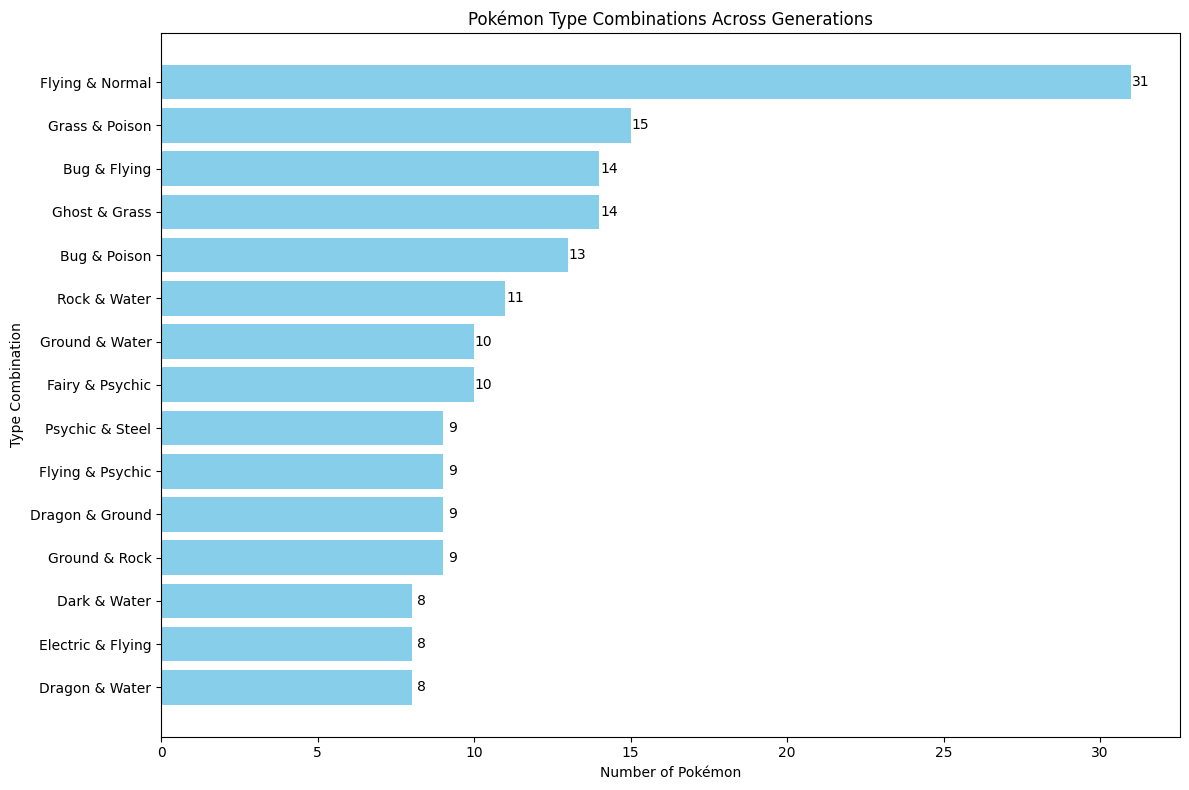

In [11]:
#I only want to show the top 15
top_15_combination = sorted_type_combination.head(n=15)

# Plotting the stacked bar chart

plt.figure(figsize=(12, 8))
bars = plt.barh(top_15_combination['type_combination'], top_15_combination['count'], color='skyblue') #Horizontal bar
plt.xlabel('Number of Pokémon')
plt.ylabel('Type Combination')
plt.title('Pokémon Type Combinations Across Generations')
plt.gca().invert_yaxis()  # To have the highest count at the top

#Add the count to the bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, f'{int(width)}', ha='center', va='center')

plt.tight_layout()
plt.show()

Hello, region birdies!!!

# 3. Single Type v Dual Type Stats
Excluding legendaries ofc

In [12]:
## Adding 'legendary' information to the table

#Since this dataset doesn't have legendary information, we will add the column manually

#To make it faster, we will assign True value to the specific legendary pokedex ID
legendary_ids = [
    144, 145, 146, 150, 151, 243, 244, 245, 249, 250, 251, 377, 378, 379,
    380, 381, 382, 383, 384, 385, 386, 480, 481, 482, 483, 484, 485, 486,
    487, 488, 489, 490, 491, 492, 493, 638, 639, 640, 641, 642, 643, 644,
    645, 646, 647, 648, 649, 716, 717, 718, 772, 773, 785, 786, 787, 788,
    791, 792, 800, 802, 807, 888, 889, 890, 891, 892, 894, 895, 896, 897,
    898, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010
]

df_pokemon['legendary'] = df_pokemon['ID'].isin(legendary_ids) #using isin to assign True value if ID is found in legendary_ids

Let's count how many single type and dual type pokemon (excluding the legendaries)

In [13]:
# Filtering legendary pokemons
df_non_legendary = df_pokemon[df_pokemon['legendary'] == False]

single_type_count = df_non_legendary['Type2'].isna().sum() #Type 2 is null
dual_type_count = df_non_legendary['Type2'].notna().sum() #Type 2 is not null

print(f'Number of single-type non-legendary Pokémon: {single_type_count}')
print(f'Number of dual-type non-legendary Pokémon: {dual_type_count}')

Number of single-type non-legendary Pokémon: 500
Number of dual-type non-legendary Pokémon: 575


Let's try to compare the two based on the average of Total stats.

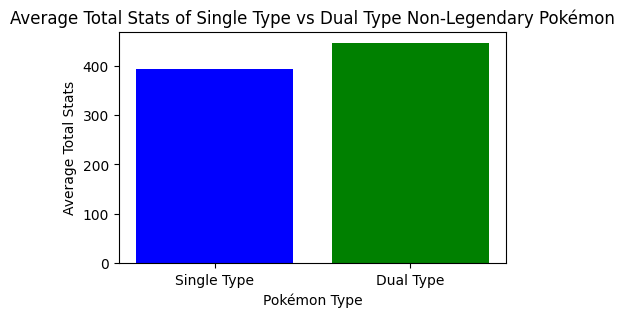

In [14]:
## Total Stats Mean Comparison

single_type_stats = df_non_legendary[df_non_legendary['Type2'].isna()]['Total'].mean()
dual_type_stats = df_non_legendary[df_non_legendary['Type2'].notna()]['Total'].mean()

# Ploting the bar chart
labels = ['Single Type', 'Dual Type']
stats = [single_type_stats, dual_type_stats]
plt.figure(figsize=(5, 3))
plt.bar(labels, stats, color=['blue', 'green'])
plt.xlabel('Pokémon Type')
plt.ylabel('Average Total Stats')
plt.title('Average Total Stats of Single Type vs Dual Type Non-Legendary Pokémon')
plt.show()

Ok so turns out Dual Type Pokemon is statistically better than Single Types.

I'm wondering how many Single Type Pokemon that exceeds the average of Dual Type's Total stats?

In [15]:
# Check if there are any Single Type Pokémon with total stats higher than the average Dual Type stats
single_type_higher_stats = df_non_legendary[(df_non_legendary['Type2'].isna()) & (df_non_legendary['Total'] > dual_type_stats)]
print(f"Number of single type pokemon with higher stats that average of dual type: {single_type_higher_stats['ID'].count()}")

Number of single type pokemon with higher stats that average of dual type: 195


In [16]:
print(single_type_higher_stats[['ID','Name','Type1','Total']].head(n=10))

    ID                      Name     Type1  Total
11   9                 Blastoise     Water    530
12   9  Blastoise Mega Blastoise     Water    630
31  24                     Arbok    Poison    448
34  26                    Raichu  Electric    485
38  28                 Sandslash    Ground    450
47  36                  Clefable     Fairy    483
50  38                 Ninetales      Fire    505
73  55                   Golduck     Water    500
75  57                  Primeape  Fighting    455
78  59                  Arcanine      Fire    555


# [WIP] Best Team Composition

Here I'm trying to create a program to generate the best team composition

My criterion for best team are:
* Must be non-legendary
* Team of 6
* High type coverage - can accomodate various type in 1 team
* Have a high synergy score (i.e. complement all roles, high number in various stats, etc. I will define the scoring system later)

Unfortunately, notebook memory cannot support this. I will move to another place. Bye
